In [0]:
import _pickle as pickle
import os
data_dir = '/content/drive/My Drive/'
training_file = os.path.join(data_dir,'train.p')
testing_file = os.path.join(data_dir,'test.p')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [0]:

#Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [0]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import matplotlib.image as mpimg
import random

def split_by_class(y_data) :
    """
    Returns a dictionary whose keys are the class labels 
    and key values are list of indices with that class label.
    """
    img_index = {}
    labels = set(y_data)
    for i,y in enumerate(y_data):
      if y not in img_index.keys():
          img_index[y] = [i]
      else :
          img_index[y].append(i)
    return img_index
    

def display_sample_images(X_data, y_data, i_start='random') :
    """
    Displays images from each class, 
    i_start is the starting index in each class.
    By default, images are randomly chosen from each class
    """
    img_index = split_by_class(y_data)
    labels = list(set(y_data))[::-1]
    fig, axes = plt.subplots(6, 15, figsize=(15, 6))
    for ax in axes.flatten() :
        if labels : #labels!= 0
            i_img=0
            if i_start == 'random':
                i_img = random.choice(img_index[labels.pop()])  
            else : 
                i_img = img_index[labels.pop()][i_start]
            ax.imshow(X_train[i_img])
        ax.axis('off')

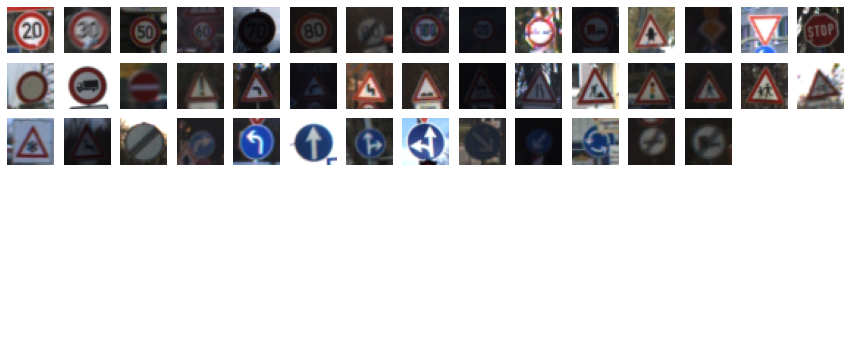

In [0]:
display_sample_images(X_train, y_train)

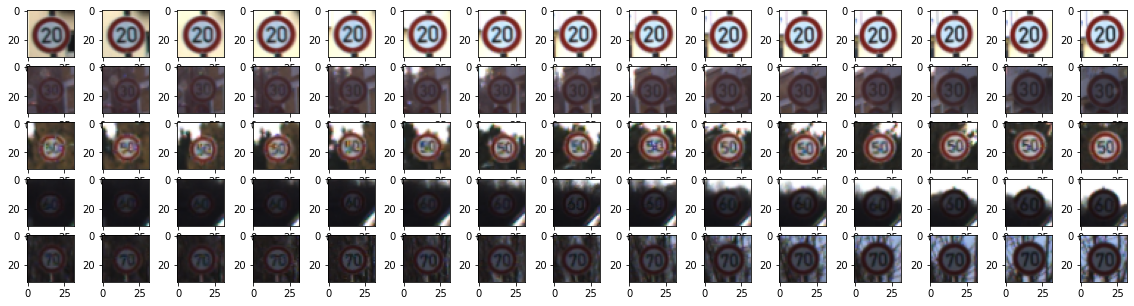

In [0]:

img_index = split_by_class(y_train)
fig, ax = plt.subplots(5,15, figsize=(20,5))
for label in range(5) :
    for i in range(15) :
        ax[label, i].imshow(X_train[img_index[label][i]])
        ax[label, i].axis('on')

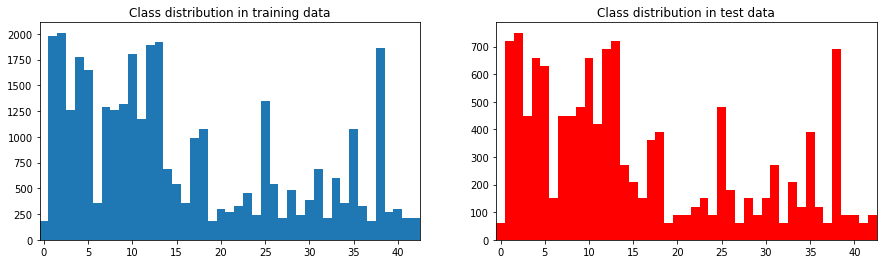

In [0]:

import numpy as np

def plot_dist(y_data, title=None, ax=None, **kwargs) :
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_classes+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5,n_classes-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)

fig,ax = plt.subplots(1,2, figsize=(15,4))
#print(ax[1])
plot_dist(y_train, title='Class distribution in training data', ax=ax[0])
plot_dist(y_test, title='Class distribution in test data', ax=ax[1], color='red')


Text(0.5, 1.0, 'Contrast norm.')

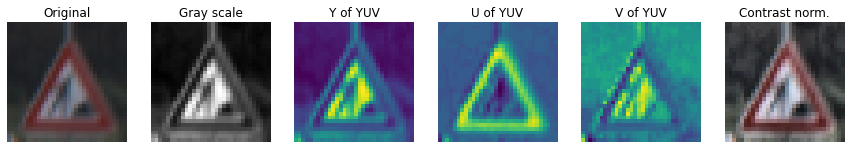

In [0]:
import cv2
import random
from sklearn.utils import shuffle

def MinMaxNorm(image, a=-.5, b=.5) :
    Xmin, Xmax = np.min(image), np.max(image)
    return (image-Xmin)*(b-a)/(Xmax-Xmin)

def AbsNorm(image, a=-.5, b=0.5, col_min=0, col_max=255) :
    return (image-col_min)*(b-a)/(col_max-col_min)

def grayscale_norm(image) :
    # convert to grayscale 
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return MinMaxNorm(img)

def YUV_norm(image) :
    # convert to YUV color space
    new_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # normalize the Y channel
    [y,u,v] = [new_image[:,:,i] for i in range(3)]
    new_image = np.zeros(image.shape)
    new_image[:,:,0] = MinMaxNorm(y)
    new_image[:,:,1],new_image[:,:,2] = AbsNorm(u), AbsNorm(v)
    return new_image

def contrast_norm(image) :
    # convert to  lab colorspace
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # apply adative histogram equalization 
    l = lab[:,:,0]
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4,4))
    cl = clahe.apply(l)
    lab[:,:,0] = cl
    # convert back to RGB and scale values 
    img =  cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    new_img = np.zeros(image.shape)
    for i in range(3) :
        new_img[:,:,i] = AbsNorm(img[:,:,i])
    return new_img

img_index = split_by_class(y_train)
img = X_train[img_index[25][20]]
fig, ax = plt.subplots(1,6, figsize=(15,3))
for axes in ax :
    axes.axis('off')
# original image
ax[0].imshow(img)
ax[0].set_title('Original')
# grayscale normalized 
ax[1].imshow(grayscale_norm(img), cmap='gray')
ax[1].set_title('Gray scale')
# YUV normalized (Y channel) 
ax[2].imshow(YUV_norm(img)[:,:,0])
ax[2].set_title('Y of YUV')
# YUV normalized (U channel) 
ax[3].imshow(YUV_norm(img)[:,:,1])
ax[3].set_title('U of YUV')
# YUV normalized (V channel) 
ax[4].imshow(YUV_norm(img)[:,:,2])
ax[4].set_title('V of YUV')
# Contrast normalized 
ax[5].imshow(contrast_norm(img))
ax[5].set_title('Contrast norm.')

New training data shape is :  (33509, 32, 32, 3)
Validation data shape is :  (1290, 32, 32, 3)


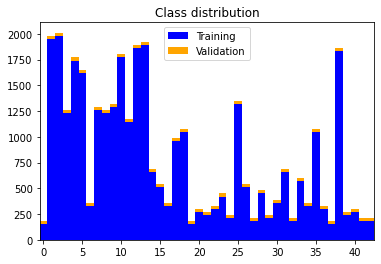

In [0]:

def split_train_validation(X_data, y_data) :
    """
    Splits data into training and validations sets based on tracks
    such that all images from a track are confined to either training 
    or validation sets but not both.
    """
    X_train_new, y_train_new = [],[]
    X_validation, y_validation = [], []
    
    n_per_track = 30 # images per track
    img_index = split_by_class(y_data)
    for label in range(n_classes) : 
        indices = img_index[label]
        n_tracks = round(len(indices)/n_per_track) # number of tracks for this label
        X_list = np.array_split(X_data[indices[0]:indices[-1]+1], n_tracks)
        y_list = np.array_split(y_data[indices[0]:indices[-1]+1], n_tracks)
        X_list,y_list = shuffle(X_list,y_list, random_state=0)
        X_validation += X_list[:1]
        y_validation += y_list[:1]
        X_train_new += X_list[1:]
        y_train_new += y_list[1:]
        
    return (np.concatenate(X_train_new), np.concatenate(y_train_new), 
            np.concatenate(X_validation), np.concatenate(y_validation))

# sanity check
X_train_new, y_train_new, X_validation, y_validation = split_train_validation(X_train, y_train)
print("New training data shape is : ", X_train_new.shape)
print("Validation data shape is : ", X_validation.shape)
plot_dist([y_train_new, y_validation], title='Class distribution', 
          label=['Training','Validation'], color=['blue','orange'])

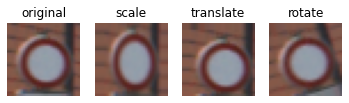

In [0]:
def scale(img, x_scale=0.85, y_scale=1.15) :
    r,c = img.shape[:-1]
    scaled_img = cv2.resize(img,None,fx=x_scale,fy=y_scale)
    new_img = cv2.copyMakeBorder(scaled_img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    r0,c0 = round((rows-r)/2), round((cols-c)/2)
    return new_img[r0:r0+r, c0:c0+c]
    
# translation
def translate(img, delta_x=2, delta_y=-2):
    r,c = img.shape[:-1]
    new_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    r0,c0 = round((rows-r)/2)+delta_y, round((cols-c)/2)-delta_x
    return new_img[r0:r0+r, c0:c0+c]

# rotation
def rotate(img, theta=18):
    r,c = img.shape[:-1]
    new_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1)
    new_img = cv2.warpAffine(new_img,M,(cols,rows))
    r0,c0 = round((rows-r)/2), round((cols-c)/2)
    return new_img[r0:r0+r, c0:c0+c]

# check if the transformations work
img = X_train[img_index[15][200]]
def original(img) : return img
fig, ax = plt.subplots(1,4, figsize=(6,2))
for i,transform in enumerate([original, scale, translate, rotate]) :
    ax[i].imshow(transform(img))
    ax[i].axis('off')
    ax[i].set_title(transform.__name__)


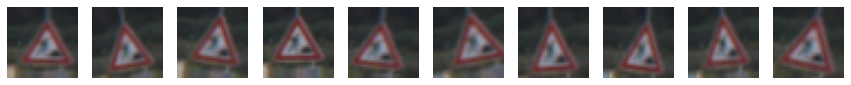

In [0]:
random_scale = lambda img : scale(img, x_scale=random.uniform(0.85,1.1), y_scale=random.uniform(0.85,1.1))
random_translate = lambda img : translate(img, delta_x=random.randint(-2,2), delta_y=random.randint(-2,2))
random_rotate = lambda img : rotate(img, theta=random.uniform(-17.,17.))

def random_transform(img) :
    new_img = img
    transform_list = [random_scale, random_translate, random_rotate]
    random.shuffle(transform_list)
    for transform in transform_list :
        new_img = transform(new_img)
    return new_img

# check
img = X_train[img_index[25][10]]
fig, ax = plt.subplots(1,10, figsize=(15,2))
for i in range(10) :
    ax[i].imshow(random_transform(img))
    ax[i].axis('off')

In [0]:
from tqdm import tqdm

def perturb_data(X_data, y_data):
    """
    splits dataset retaining half the original images 
    while perturbing the other half of the images 
    """
    X_old, y_old = [], []
    X_new, y_new = [], []
    images_pbar = tqdm(X_data, unit='images', desc='Original data perturbation')
    for i,img in enumerate(images_pbar) :
        if i%2 == 0 : 
            X_old.append(img) 
            y_old.append(y_data[i])
        else :
            X_new.append(random_transform(img))
            y_new.append(y_data[i])
    return (np.array(X_old), np.array(y_old), 
            np.array(X_new), np.array(y_new))
        

def augment_data(X_data, y_data, n=300):
    """
    augments dataset so that there are n images per class
    """
    X_data_fake, y_data_fake = [],[]
    img_index = split_by_class(y_data)
    labels_pbar = tqdm(range(n_classes), unit='class', desc='Data augmentation')
    for label in labels_pbar:
        print(len(img_index[label])) # check for all 43 labels
        n_fake = n-len(img_index[label])
        if n_fake <= 0 : continue
        for i in range(n_fake):
            i_img = random.choice(img_index[label])
            img = X_data[i_img]
            X_data_fake.append(random_transform(img))
            y_data_fake.append(label)
    return np.array(X_data_fake),np.array(y_data_fake)

In [0]:
from time import sleep
print('Training dataset augmentation')
sleep(1)
X_train_given, y_train_given, X_train_pert, y_train_pert = perturb_data(X_train_new, y_train_new)
X_train_fake, y_train_fake = augment_data(X_train_new, y_train_new, n=5000)
del X_train_new, y_train_new

Training dataset augmentation


Data augmentation:   0%|          | 0/43 [00:00<?, ?class/s]

150


Data augmentation:   2%|▏         | 1/43 [00:00<00:15,  2.75class/s]

1950


Data augmentation:   5%|▍         | 2/43 [00:00<00:13,  3.04class/s]

1980


Data augmentation:   7%|▋         | 3/43 [00:00<00:11,  3.37class/s]

1230


Data augmentation:   9%|▉         | 4/43 [00:01<00:11,  3.43class/s]

1740


Data augmentation:  12%|█▏        | 5/43 [00:01<00:10,  3.60class/s]

1620


Data augmentation:  14%|█▍        | 6/43 [00:01<00:10,  3.66class/s]

330


Data augmentation:  16%|█▋        | 7/43 [00:01<00:10,  3.41class/s]

1260


Data augmentation:  19%|█▊        | 8/43 [00:02<00:10,  3.39class/s]

1230


Data augmentation:  21%|██        | 9/43 [00:02<00:09,  3.48class/s]

1290


Data augmentation:  23%|██▎       | 10/43 [00:02<00:09,  3.56class/s]

1770


Data augmentation:  26%|██▌       | 11/43 [00:03<00:08,  3.72class/s]

1140


Data augmentation:  28%|██▊       | 12/43 [00:03<00:08,  3.65class/s]

1860


Data augmentation:  30%|███       | 13/43 [00:03<00:07,  3.84class/s]

1890


Data augmentation:  33%|███▎      | 14/43 [00:03<00:07,  3.94class/s]

660


Data augmentation:  35%|███▍      | 15/43 [00:04<00:07,  3.59class/s]

510


Data augmentation:  37%|███▋      | 16/43 [00:04<00:07,  3.39class/s]

330


Data augmentation:  40%|███▉      | 17/43 [00:04<00:08,  3.25class/s]

960


Data augmentation:  42%|████▏     | 18/43 [00:05<00:07,  3.25class/s]

1050


Data augmentation:  44%|████▍     | 19/43 [00:05<00:07,  3.32class/s]

150


Data augmentation:  47%|████▋     | 20/43 [00:05<00:07,  3.17class/s]

270


Data augmentation:  49%|████▉     | 21/43 [00:06<00:07,  3.09class/s]

240


Data augmentation:  51%|█████     | 22/43 [00:06<00:06,  3.05class/s]

300


Data augmentation:  53%|█████▎    | 23/43 [00:06<00:06,  3.04class/s]

420


Data augmentation:  56%|█████▌    | 24/43 [00:07<00:06,  3.06class/s]

210


Data augmentation:  58%|█████▊    | 25/43 [00:07<00:05,  3.01class/s]

1320


Data augmentation:  60%|██████    | 26/43 [00:07<00:05,  3.14class/s]

510


Data augmentation:  63%|██████▎   | 27/43 [00:08<00:05,  3.13class/s]

180


Data augmentation:  65%|██████▌   | 28/43 [00:08<00:04,  3.04class/s]

450


Data augmentation:  67%|██████▋   | 29/43 [00:08<00:04,  3.05class/s]

210


Data augmentation:  70%|██████▉   | 30/43 [00:09<00:04,  3.03class/s]

360


Data augmentation:  72%|███████▏  | 31/43 [00:09<00:04,  3.00class/s]

660


Data augmentation:  74%|███████▍  | 32/43 [00:09<00:03,  3.06class/s]

180


Data augmentation:  77%|███████▋  | 33/43 [00:10<00:03,  2.99class/s]

569


Data augmentation:  79%|███████▉  | 34/43 [00:10<00:03,  2.97class/s]

330


Data augmentation:  81%|████████▏ | 35/43 [00:10<00:02,  2.97class/s]

1050


Data augmentation:  84%|████████▎ | 36/43 [00:11<00:02,  3.12class/s]

300


Data augmentation:  86%|████████▌ | 37/43 [00:11<00:01,  3.03class/s]

150


Data augmentation:  88%|████████▊ | 38/43 [00:11<00:01,  2.96class/s]

1830


Data augmentation:  91%|█████████ | 39/43 [00:11<00:01,  3.28class/s]

240


Data augmentation:  93%|█████████▎| 40/43 [00:12<00:00,  3.15class/s]

270


Data augmentation:  95%|█████████▌| 41/43 [00:12<00:00,  3.04class/s]

180


Data augmentation:  98%|█████████▊| 42/43 [00:13<00:00,  2.95class/s]

180


Data augmentation: 100%|██████████| 43/43 [00:13<00:00,  3.22class/s]


(16755,)
(16754,)
(181491,)


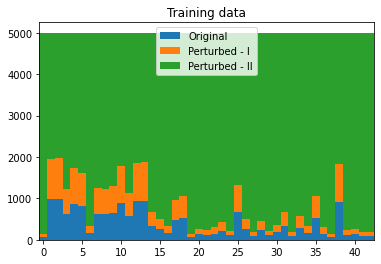

In [0]:
plot_dist([y_train_given,y_train_pert, y_train_fake], title='Training data', \
          label=['Original','Perturbed - I','Perturbed - II'])
print(y_train_given.shape)
print(y_train_pert.shape)
print(y_train_fake.shape)

In [0]:
from sklearn.utils import shuffle
from time import sleep 

# combine training data, shuffle and apply pre-processing 
print('Preparing training data...')
X_train = np.concatenate((X_train_given, X_train_pert, X_train_fake))
print(X_train.shape)
y_train = np.concatenate((y_train_given, y_train_pert, y_train_fake))
print(y_train.shape)
X_train, y_train = shuffle(X_train, y_train)
del X_train_given, X_train_pert, X_train_fake, \
    y_train_given, y_train_pert, y_train_fake # free memory 
sleep(1)
images_pbar = tqdm(X_train, unit='images')
X_train = np.zeros(X_train.shape)
for i,img in enumerate(images_pbar) : 
    X_train[i] = contrast_norm(img) 
print('Done')

# combine validation data, shuffle and apply pre-processing 
print('Preparing validation data...')
X_validation, y_validation = shuffle(X_validation, y_validation)
sleep(1)
images_pbar = tqdm(X_validation, unit='images')
X_validation = np.zeros(X_validation.shape)
for i,img in enumerate(images_pbar) : 
    X_validation[i] = contrast_norm(img) 
print('Done')
    
# pre-process test set images
print('Preparing test data...')
sleep(1)
images_pbar = tqdm(X_test, unit='images')
X_test = np.zeros(X_test.shape)
for i,img in enumerate(images_pbar) : 
    X_test[i] = contrast_norm(img) 
sleep(1)

Preparing training data...
(215000, 32, 32, 3)
(215000,)


100%|██████████| 215000/215000 [00:45<00:00, 4771.98images/s]


Done
Preparing validation data...


100%|██████████| 1290/1290 [00:00<00:00, 4684.42images/s]


Done
Preparing test data...


100%|██████████| 12630/12630 [00:02<00:00, 4976.26images/s]


Training data shape :  (215000, 32, 32, 3)
Validation data shape :  (1290, 32, 32, 3)
Test data shape :  (12630, 32, 32, 3)


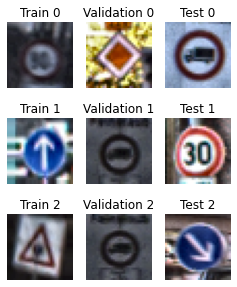

In [0]:
fig, ax = plt.subplots(3,3, figsize=(4,5))
for i in range(3) :
    ax[i,0].imshow(X_train[i])
    ax[i,0].set_title('Train '+str(i))
    ax[i,1].imshow(X_validation[i])
    ax[i,1].set_title('Validation '+str(i))
    ax[i,2].imshow(X_test[i])
    ax[i,2].set_title('Test '+str(i))
for axes in ax.flatten() :
    axes.axis('off')

print('Training data shape : ', X_train.shape)
print('Validation data shape : ', X_validation.shape)
print('Test data shape : ', X_test.shape)

In [0]:
import os
DIR = '/content/drive/My Drive/models'
if not os.path.exists(DIR) :
    os.makedirs(DIR)

In [0]:

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow.keras.layers import Flatten

keep_prob = tf.placeholder(tf.float32) # for fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32) # for convolutional layers
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

class VGGnet :  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.0007) :
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x32.
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # ReLu Activation.
        self.conv1 = tf.nn.relu(self.conv1)

        # Layer 2: Convolutional. Input = 32x32x32. Output = 32x32x32.
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        # ReLu Activation.
        self.conv2 = tf.nn.relu(self.conv2)

        # Pooling. Input = 32x32x32. Output = 16x16x32.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv) # dropout

        # Layer 3: Convolutional. Input = 16x16x32. Output = 16x16x64.
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Activation.
        self.conv3 = tf.nn.relu(self.conv3)

        # Layer 4: Convolutional. Input = 16x16x32. Output = 16x16x64.
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # ReLu Activation.
        self.conv4 = tf.nn.relu(self.conv4)

        # Pooling. Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        # Layer 5: Convolutional. Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Activation.
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 6: Convolutional. Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Activation.
        self.conv6 = tf.nn.relu(self.conv6)

        # Pooling. Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Flatten. Input = 4x4x128. Output = 2048.
        self.fc0   = Flatten()(self.conv6)

        # Layer 7: Fully Connected. Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # ReLu Activation.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Layer 8: Fully Connected. Input = 128. Output = 128.
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # ReLu Activation.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Layer 9: Fully Connected. Input = 128. Output = n_out.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y,logits=self.logits)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # accuracy 
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # save all variables
        self.saver = tf.train.Saver()
    
    def y_predict(self, X_data, BATCH_SIZE=64) :
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples


In [0]:
EPOCHS = 15
BATCH_SIZE = 64
model_1 = VGGnet(n_out = n_classes)
model_name = "model_1"


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training...")
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(model_1.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = model_1.evaluate(X_validation, y_validation)
        print("EPOCH {} : Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))

    model_1.saver.save(sess, os.path.join(DIR,model_name))
    print("Model saved")

Training...
EPOCH 1 : Validation Accuracy = 0.630
EPOCH 2 : Validation Accuracy = 0.933
EPOCH 3 : Validation Accuracy = 0.978
EPOCH 4 : Validation Accuracy = 0.993
EPOCH 5 : Validation Accuracy = 0.985
EPOCH 6 : Validation Accuracy = 0.985
EPOCH 7 : Validation Accuracy = 0.991
EPOCH 8 : Validation Accuracy = 0.985
EPOCH 9 : Validation Accuracy = 0.990
EPOCH 10 : Validation Accuracy = 0.992
EPOCH 11 : Validation Accuracy = 0.995
EPOCH 12 : Validation Accuracy = 0.990
EPOCH 13 : Validation Accuracy = 0.996
EPOCH 14 : Validation Accuracy = 0.988
EPOCH 15 : Validation Accuracy = 0.993
Model saved


In [0]:
with tf.Session() as sess:
    model_1.saver.restore(sess, os.path.join(DIR, "model_1"))
    #test_accuracy = model_1.evaluate(X_test, y_test)
    y_pred = model_1.y_predict(X_test)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/models/model_1
Test Accuracy = 0.979


Text(0.5, 0, 'Predicted label')

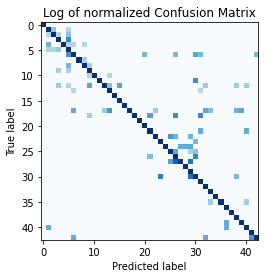

In [0]:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001+cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [0]:
import pandas as pd
sign_names = pd.read_csv('/content/drive/My Drive/signnames.csv')
sign_names.head(10)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


(225, 225, 3)
(345, 359, 3)


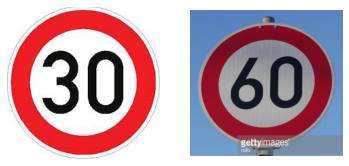

In [0]:
import glob
img_files = glob.glob('/content/drive/My Drive/test_images/*.jpg')
n_new = len(img_files)
new_data = np.zeros((n_new, 32,32,3), dtype=np.uint8)
fig, ax = plt.subplots(1,n_new)

for i in range(n_new) :
    img = plt.imread(img_files[i])
    print(img.shape)
    ax[i].imshow(img)
    ax[i].axis('off')
    img = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA) # resize to 32x32
    new_data[i] = img

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/models/model_1


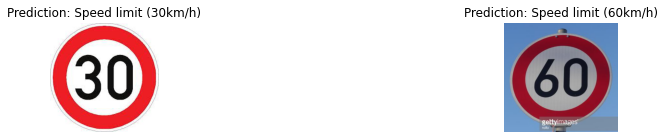

In [0]:
def y_predict_model(X_data, top_k=1):
    num_examples = len(X_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        model_1.saver.restore(sess, os.path.join(DIR, "model_1"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(model_1.logits), k=top_k), 
                             feed_dict={x:X_data, keep_prob:1, keep_prob_conv:1})
    return y_prob,y_pred


# preprocess data  :
new_data_proc = np.zeros(new_data.shape)
for i in range(n_new):
    new_data_proc[i] = contrast_norm(new_data[i])
    
# make predictions
_, y_pred = y_predict_model(new_data_proc)

# show the prediction results
fig, ax = plt.subplots(1,n_new, figsize=(15,2))
for i in range(n_new) :
    img = plt.imread(img_files[i])
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title('Prediction: '+sign_names.iloc[y_pred[i][0]]['SignName'])

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/models/model_1


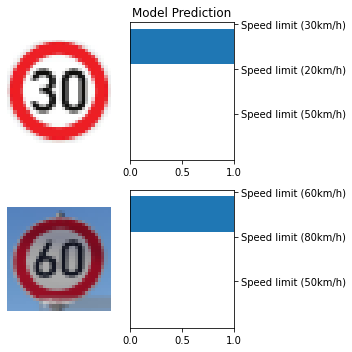

In [0]:
def visualize_models(X_data) :
    n_examples = len(X_data)
    fig, ax = plt.subplots(n_examples, 2,figsize=(5,5))
    
    X_data_proc = np.zeros(X_data.shape)
    for i in range(n_examples):
        X_data_proc[i] = contrast_norm(X_data[i])
    prob, pred = y_predict_model(X_data_proc, top_k=3)
    
    for i in range(n_examples) :
        labels = pred[i]
        names = [sign_names.iloc[l]['SignName'] for l in labels]
        bar_locations = np.arange(3)[::-1]
        ax[i,0].imshow(X_data[i])
        ax[i,0].axis('off')
        ax[i,1].barh(bar_locations, prob[i])
        ax[i,1].set_yticks(0.5+bar_locations)
        ax[i,1].set_yticklabels(names)
        ax[i,1].yaxis.tick_right()
        ax[i,1].set_xlim([0,1])
    ax[0,1].set_title('Model Prediction')
    fig.tight_layout()
    
visualize_models(new_data)